In [37]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [38]:
import sklearn

In [39]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [43]:
pos_final_test = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

# pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') |

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [104]:
hadm_features

,"('abn_percent', 50868)","('abn_percent', 50882)","('abn_percent', 50902)","('abn_percent', 50912)","('abn_percent', 50931)","('abn_percent', 50971)","('abn_percent', 50983)","('abn_percent', 51006)","('abn_percent', 51221)","('abn_percent', 51222)","('abn_percent', 51248)","('abn_percent', 51249)","('abn_percent', 51250)","('abn_percent', 51265)","('abn_percent', 51277)","('abn_percent', 51279)","('abn_percent', 51301)",gender,age,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER,ethnicity_UNKNOWN
0,0.965474,2.958378,-0.236040,1.775190,1.059667,-0.391195,1.493924,1.799380,0.349508,0.271983,-0.631844,-0.650272,-0.461956,0.187436,-0.498606,0.667032,1.770726,0.0,1.153246,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.346028,-0.552401,1.321157,0.417674,0.157940,-0.391195,-0.411612,-0.797160,0.783332,0.756098,-0.631844,2.157373,1.358548,-0.600116,-0.498606,0.667032,-0.324457,0.0,-0.441483,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.346028,0.314458,3.224398,1.629742,1.059667,0.293753,1.684477,1.474812,-1.602697,-1.664476,1.576326,-0.650272,2.572217,-0.239155,-0.498606,0.667032,0.133864,1.0,1.359017,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.346028,-0.552401,-0.582084,-0.551980,-1.645515,-0.391195,-0.411612,-0.797160,0.783332,0.756098,1.891779,-0.650272,2.572217,-0.600116,-0.498606,0.667032,-0.848253,0.0,-1.316012,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.346028,-0.552401,-0.582084,-0.551980,1.059667,-0.391195,-0.411612,-0.797160,-1.602697,0.756098,-0.631844,-0.650272,-0.461956,-0.600116,-0.498606,0.667032,1.770726,0.0,-1.110241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8555,-0.346028,-0.552401,-0.582084,-0.551980,-1.645515,-0.391195,-0.411612,-0.797160,-1.602697,0.756098,-0.631844,-0.650272,-0.461956,-0.600116,-0.498606,0.667032,-0.848253,1.0,-0.132826,0.0,0.0,0.0,0.0,1.0,0.0
8556,-0.346028,-0.552401,-0.582084,2.356982,-1.645515,-0.391195,-0.411612,1.799380,0.783332,0.756098,1.891779,-0.650272,2.572217,-0.600116,-0.498606,0.667032,-0.848253,0.0,1.050360,0.0,0.0,0.0,0.0,0.0,0.0
8557,-0.346028,1.831461,2.801456,-0.551980,1.059667,-0.391195,4.828610,-0.797160,0.783332,0.756098,-0.631844,-0.650272,2.572217,-0.600116,-0.498606,0.667032,0.024740,0.0,1.564789,0.0,1.0,0.0,0.0,0.0,0.0
8558,2.308203,-0.459524,1.230526,-0.551980,0.802030,-0.065030,2.208499,1.304801,0.713155,0.756098,-0.631844,0.010350,-0.461956,1.608120,2.332418,0.667032,-0.000936,0.0,0.433046,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [47]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [48]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7362
Target=1:  1198


In [73]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [178]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

## Logistic Regression

### Basic

In [74]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 3.23 s, sys: 385 ms, total: 3.61 s
Wall time: 2.36 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8315
Accuracy Score: 74.53%
_______________________________________________
Classification Report:	Precision Score: 31.85%
			Recall Score: 71.67%
			F1 score: 44.10%
			ROC_AUC score: 73.33%
_______________________________________________
Confusion Matrix: 
 [[1104  368]
 [  68  172]]



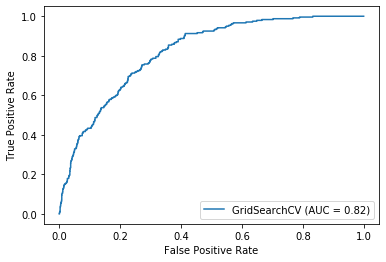

age                                 0.924954
('abn_percent', 51006)              0.367268
('abn_percent', 51277)              0.365247
('abn_percent', 51221)              0.356932
('abn_percent', 51222)              0.336503
('abn_percent', 50912)              0.293142
('abn_percent', 50931)              0.199714
('abn_percent', 51249)              0.149206
ethnicity_BLACK/AFRICAN AMERICAN    0.148948
gender                              0.140296
('abn_percent', 50971)              0.061245
('abn_percent', 51301)              0.049881
('abn_percent', 51250)              0.045587
('abn_percent', 50882)              0.037655
('abn_percent', 51248)              0.029490
('abn_percent', 50868)              0.017237
('abn_percent', 50902)              0.014745
('abn_percent', 51265)              0.000404
dtype: float64


In [75]:
results(grid_log)

In [ ]:
from sklearn.feature_selection import RFECV
selector = RFECV(grid_log, step=1, cv=5)
selector = selector.fit(X_train, y_train)
selector.support_

### Under Sampling using Near Miss

In [78]:
%%time
params ={'C':np.linspace(1e-2,100,100)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 8.44 s, sys: 727 ms, total: 9.17 s
Wall time: 5.55 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01...
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 33.339999999999996}
Best CV score:  0.9296
Accuracy Score: 55.43%
_______________________________________________
Classification Report:	Precision Score: 21.36%
			Recall Score: 81.25%
			F1 score: 33.82%
			ROC_AUC score: 66.24%
_______________________________________________
Confusion Matrix: 
 [[754 718]
 [ 45 195]]



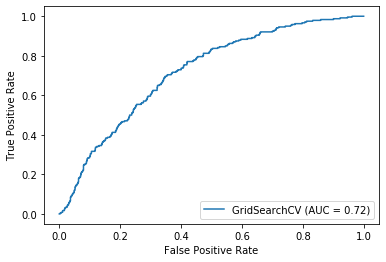

('abn_percent', 51221)              1.622480
('abn_percent', 50971)              1.099105
('abn_percent', 51222)              1.082218
ethnicity_BLACK/AFRICAN AMERICAN    1.076821
ethnicity_ASIAN                     1.068087
ethnicity_UNKNOWN                   1.008492
('abn_percent', 50882)              0.832668
ethnicity_OTHER                     0.791652
ethnicity_HISPANIC/LATINO           0.786223
('abn_percent', 51250)              0.755790
('abn_percent', 50868)              0.733121
('abn_percent', 51277)              0.721822
('abn_percent', 51249)              0.699285
('abn_percent', 50983)              0.697415
age                                 0.658560
('abn_percent', 50902)              0.612731
('abn_percent', 51006)              0.504567
('abn_percent', 51248)              0.495831
('abn_percent', 51265)              0.452326
('abn_percent', 51301)              0.337373
('abn_percent', 50912)              0.221859
('abn_percent', 51279)              0.191078
gender    

In [79]:
results(grid_log_under)

## Random Forest

### RF_Under Sampling using Near Miss

In [134]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(420,421,1),
            'max_depth': range(10,20,2)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 27.9 s, sys: 834 ms, total: 28.8 s
Wall time: 1min 11s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(10, 20, 2),
                         'n_estimators': range(420, 421)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 420}
Best CV score:  0.9264
Accuracy Score: 53.21%
_______________________________________________
Classification Report:	Precision Score: 20.93%
			Recall Score: 84.17%
			F1 score: 33.53%
			ROC_AUC score: 66.17%
_______________________________________________
Confusion Matrix: 
 [[709 763]
 [ 38 202]]



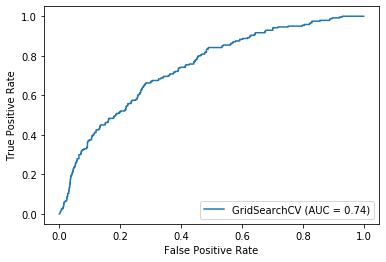

('abn_percent', 51006)                     0.150409
('abn_percent', 50912)                     0.107320
('abn_percent', 51277)                     0.105265
('abn_percent', 50882)                     0.079788
('abn_percent', 51249)                     0.076476
('abn_percent', 50902)                     0.074472
('abn_percent', 51250)                     0.060910
('abn_percent', 51248)                     0.054065
('abn_percent', 50971)                     0.046735
('abn_percent', 50983)                     0.043914
age                                        0.038256
('abn_percent', 50868)                     0.036468
('abn_percent', 51301)                     0.030795
('abn_percent', 51265)                     0.030604
('abn_percent', 50931)                     0.016718
('abn_percent', 51221)                     0.016409
('abn_percent', 51222)                     0.010385
('abn_percent', 51279)                     0.009773
gender                                     0.004390
ethnicity_BL

In [121]:
results(grid_rf_under)

## Gradient Boost

### GB_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_features, param_range=range(5, 30, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


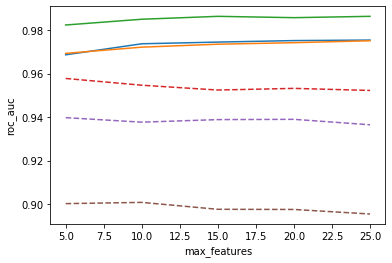

In [203]:
plot_val_curve(GradientBoostingClassifier(), 'max_features', range(5,30,5),X_res_under, y_res_under)

In [200]:
%%time
param_grid={'n_estimators':range(20,200,20),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

CPU times: user 8.88 s, sys: 175 ms, total: 9.06 s
Wall time: 11 s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'n_estimators': range(20, 200, 20)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'n_estimators': 80}
Best CV score:  0.9284
Accuracy Score: 53.86%
_______________________________________________
Classification Report:	Precision Score: 21.23%
			Recall Score: 84.58%
			F1 score: 33.95%
			ROC_AUC score: 66.71%
_______________________________________________
Confusion Matrix: 
 [[719 753]
 [ 37 203]]



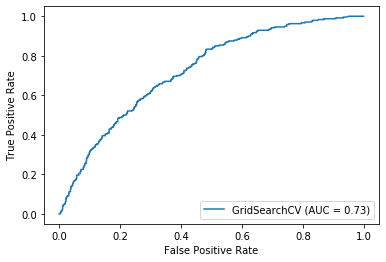

('abn_percent', 51006)                     0.254709
('abn_percent', 51277)                     0.109275
('abn_percent', 50912)                     0.094109
('abn_percent', 51249)                     0.071846
('abn_percent', 51250)                     0.071665
('abn_percent', 50902)                     0.067564
('abn_percent', 50882)                     0.062880
('abn_percent', 51248)                     0.060593
('abn_percent', 50971)                     0.043067
('abn_percent', 50983)                     0.030344
('abn_percent', 50868)                     0.028831
age                                        0.024883
('abn_percent', 51301)                     0.022124
('abn_percent', 51265)                     0.020612
('abn_percent', 51221)                     0.017185
('abn_percent', 51222)                     0.009631
('abn_percent', 50931)                     0.003566
('abn_percent', 51279)                     0.003124
ethnicity_BLACK/AFRICAN AMERICAN           0.001684
ethnicity_AS

In [201]:
results(grid_gb_under)

In [204]:
param_grid={'n_estimators':range(80,81,1),
            'max_depth':range(2,9,2),
#             'min_samples_split':range(20,100,30),
            'max_features':range(7,12,2),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(2, 9, 2),
                         'max_features': range(7, 12, 2),
                         'n_estimators': range(80, 81)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 2, 'max_features': 11, 'n_estimators': 80}
Best CV score:  0.9303
Accuracy Score: 56.07%
_______________________________________________
Classification Report:	Precision Score: 21.81%
			Recall Score: 82.50%
			F1 score: 34.49%
			ROC_AUC score: 67.13%
_______________________________________________
Confusion Matrix: 
 [[762 710]
 [ 42 198]]



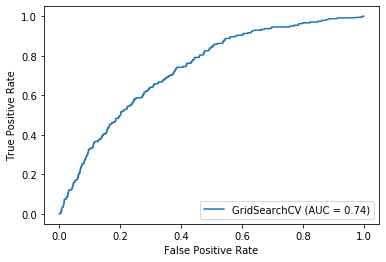

('abn_percent', 51006)                     0.239039
('abn_percent', 51277)                     0.107124
('abn_percent', 50912)                     0.089566
('abn_percent', 51249)                     0.088628
('abn_percent', 50882)                     0.079207
('abn_percent', 50902)                     0.073878
('abn_percent', 51248)                     0.068987
('abn_percent', 51250)                     0.067505
('abn_percent', 50971)                     0.043552
('abn_percent', 50983)                     0.026785
('abn_percent', 51265)                     0.023995
('abn_percent', 50868)                     0.023909
('abn_percent', 51301)                     0.022970
age                                        0.019729
('abn_percent', 51221)                     0.014288
('abn_percent', 51222)                     0.006130
('abn_percent', 51279)                     0.001921
ethnicity_BLACK/AFRICAN AMERICAN           0.001205
('abn_percent', 50931)                     0.001146
gender      

In [205]:
results(grid_gb_under)

## Gather Metrics

In [206]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)        
    return metrics

In [208]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
            (grid_gb,'gradient_boost_basic'),(grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
            (grid_rf,'random_forest_basic'),(grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
           ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,logistic_basic,0.441026,0.733333,0.716667,0.745327,0.318519
1,logistic_under,0.338248,0.662364,0.812500,0.554322,0.213582
2,logistic_over,0.433420,0.723551,0.691667,0.746495,0.315589
3,gradient_boost_basic,0.288462,0.584579,0.187500,0.870327,0.625000
4,gradient_boost_under,0.344948,0.671332,0.825000,0.560748,0.218062
5,gradient_boost_over,0.388889,0.638315,0.350000,0.845794,0.437500
6,random_forest_basic,0.256410,0.572464,0.166667,0.864486,0.555556
7,random_forest_under,0.328969,0.653465,0.837500,0.521028,0.204684
8,random_forest_over,0.433684,0.669746,0.429167,0.842874,0.438298


## Gather Best Features

In [209]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [210]:
gather_best_features(model_list)

,features,logistic_basic,features,logistic_under,features,logistic_over,features,gradient_boost_basic,features,gradient_boost_under,features,gradient_boost_over,features,random_forest_basic,features,random_forest_under,features,random_forest_over
0,age,0.924954,age,0.924954,age,0.924954,age,0.261816,"('abn_percent', 51006)",0.239039,age,0.210739,age,0.143728,"('abn_percent', 51006)",0.148302,age,0.181921
1,"('abn_percent', 51006)",0.367268,"('abn_percent', 51006)",0.367268,"('abn_percent', 51006)",0.367268,"('abn_percent', 51006)",0.257390,"('abn_percent', 51277)",0.107124,"('abn_percent', 51006)",0.115035,"('abn_percent', 51006)",0.096350,"('abn_percent', 50912)",0.111882,"('abn_percent', 51006)",0.124085
2,"('abn_percent', 51277)",0.365247,"('abn_percent', 51277)",0.365247,"('abn_percent', 51277)",0.365247,"('abn_percent', 50912)",0.195614,"('abn_percent', 50912)",0.089566,"('abn_percent', 50912)",0.098735,"('abn_percent', 50912)",0.079882,"('abn_percent', 51277)",0.096248,"('abn_percent', 50912)",0.089938
3,"('abn_percent', 51221)",0.356932,"('abn_percent', 51221)",0.356932,"('abn_percent', 51221)",0.356932,"('abn_percent', 51277)",0.119766,"('abn_percent', 51249)",0.088628,"('abn_percent', 50931)",0.056842,"('abn_percent', 50931)",0.067870,"('abn_percent', 50882)",0.081062,"('abn_percent', 50931)",0.064498
4,"('abn_percent', 51222)",0.336503,"('abn_percent', 51222)",0.336503,"('abn_percent', 51222)",0.336503,"('abn_percent', 51249)",0.041337,"('abn_percent', 50882)",0.079207,"('abn_percent', 50882)",0.054748,"('abn_percent', 51249)",0.054745,"('abn_percent', 51249)",0.076105,"('abn_percent', 51277)",0.053967
5,"('abn_percent', 50912)",0.293142,"('abn_percent', 50912)",0.293142,"('abn_percent', 50912)",0.293142,"('abn_percent', 50882)",0.031211,"('abn_percent', 50902)",0.073878,"('abn_percent', 51277)",0.052541,"('abn_percent', 50882)",0.051560,"('abn_percent', 50902)",0.074282,"('abn_percent', 50882)",0.048913
6,"('abn_percent', 50931)",0.199714,"('abn_percent', 50931)",0.199714,"('abn_percent', 50931)",0.199714,"('abn_percent', 50931)",0.024907,"('abn_percent', 51248)",0.068987,gender,0.046196,"('abn_percent', 51277)",0.051405,"('abn_percent', 51250)",0.056460,"('abn_percent', 51249)",0.046612
7,"('abn_percent', 51249)",0.149206,"('abn_percent', 51249)",0.149206,"('abn_percent', 51249)",0.149206,"('abn_percent', 50868)",0.016327,"('abn_percent', 51250)",0.067505,"('abn_percent', 51249)",0.034976,"('abn_percent', 51301)",0.051224,"('abn_percent', 51248)",0.054950,gender,0.044769
8,ethnicity_BLACK/AFRICAN AMERICAN,0.148948,ethnicity_BLACK/AFRICAN AMERICAN,0.148948,ethnicity_BLACK/AFRICAN AMERICAN,0.148948,"('abn_percent', 50971)",0.012088,"('abn_percent', 50971)",0.043552,"('abn_percent', 51301)",0.034349,"('abn_percent', 50902)",0.045172,age,0.045064,"('abn_percent', 51301)",0.037994
9,gender,0.140296,gender,0.140296,gender,0.140296,"('abn_percent', 51301)",0.006908,"('abn_percent', 50983)",0.026785,"('abn_percent', 51265)",0.030002,"('abn_percent', 51265)",0.042066,"('abn_percent', 50971)",0.043704,"('abn_percent', 50902)",0.033001
